In [124]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection for content losses done by Logistic Regression

Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [125]:
import sys
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines as p
import utils.utils_processing as pp


p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')


target = "Target_relative_contentloss_euro"


<Figure size 2000x1000 with 0 Axes>

In [126]:
## load DS for relative content loss
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")

df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)

print(df_candidates.shape)
df_candidates.tail(2)


(397, 32)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,contaminations_light,contaminations_heavy,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,NaN,130.0,NaN,1,17,2,3,1.0,1,0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,NaN,5.0,33.0,1.0,1,11,2,3,NaN,1,0,736.5


In [127]:
## impl in data_cleaning
#print(df_candidates.floors.describe())
try: 
    df_candidates = df_candidates[df_candidates.floors < 3, : ]
except:
    pass


### TODO impl this cell in data_cleaning
try:
    #if target=="Target_relative_contentloss_euro": 
    df_candidates = df_candidates.drop("floors", axis=1 )  # remove if still in ds due that it's used for shp_content_value and relative content loss
    df_candidates = df_candidates.drop("buildingtype_moon", axis=1)  # remove due to 64 % missing values   
except:
    pass
try:
    df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
    df_candidates = df_candidates.drop(["contaminations_light","contaminations_heavy"], axis=1)
    #df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
except:
    pass


print(df_candidates.shape)
df_candidates.tail(2)

(397, 29)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,NaN,130.0,NaN,1,17,2,3,1.0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,5.0,33.0,1.0,1,11,2,3,NaN,736.5


In [128]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 


Percentage of missing values per feature [%]
 Target_relative_contentloss_euro       18.0
resilience_govern_careing_increases    14.0
shp_registered_capital_euro            12.0
bage                                    7.0
hh_monthly_income_cat                   6.0
inundation_duration_h                   2.0
b_area                                  1.0
water_depth_cm                          0.0
contaminations.0                        0.0
electricity_higher_impl                 0.0
shp_avgmonthly_sale_cat                 0.0
shp_employees                           0.0
shp_sector                              0.0
shp_owner                               0.0
flood_experience                        0.0
dtype: float64 2


In [129]:
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


## Fit model 

In [130]:
# 

In [131]:
## iterate over both targets and store results 
pipe_name = "pipe_logreg"
#pipe_name = "pipe_logreg_bag"


eval_set_list = []
models_trained = {}
model_coef = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

# Load set of hyperparamters
hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")


model_name = pipe_name.split('_', 1)[1]
print( f"\nApply Logistic regression on {target}:")

## set target as binary class
df_candidates_t = df_candidates
df_candidates[target][df_candidates[target] > 0] = 1
df_candidates[target] = df_candidates[target].astype("Int64")

## clean df from remaining records containg nan
df_candidates_t.dropna(inplace=True)
## TODO test with only nan in target removed

print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
        { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")

        
X = df_candidates_t.drop(target, axis=1)  # remove bth targets from X
y = df_candidates_t[target]


from sklearn.ensemble import BaggingClassifier  
param_grid = {
    "name__estimator__penalty": ["elasticnet"],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "name__estimator__C": [1,2,3,4,5, 6, 7, 8, 9],  # inverse reularization strength
    "name__estimator__max_iter": [1,2,3,4],
    "name__estimator__l1_ratio": np.arange(0.0, 1.01, 0.25),     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "name__estimator__tol": [0.0001, 0.001, 0.01, 0.1, 0.5,],
    "name__estimator__solver": ["saga"],
    "name__estimator__class_weight": ["balanced"],
    "name__estimator__random_state": [seed],
}
model = {'model': BaggingClassifier,   # default bootstrap=True
    'kwargs': {'estimator': LogisticRegression()},  # TODO: pass 'random_state':seed to baggingregressor
    'parameters': param_grid,
    }
pipeline = Pipeline( steps = [('scaler', MinMaxScaler()), ('name', model['model'] (**model['kwargs']) ) ]  )  # pipeline for Bagging method
     # --> access params in pipline via <estimator>__<parameter> syntax , eg hyperParams for ElasticNet have to start with "name__estimator__<HyperParamName>""

## load pipe for non-transfomred model
pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

## Hyperparmater and cv setting       
param_grid = hyperparams_set[f"{model_name}_hyperparameters"]


## set cv for classification task        
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)
#cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

## inner cv with hyperparameter tuning 
model = RandomizedSearchCV(
    estimator=pipe, # pipeline
    param_distributions=param_grid, # model['parameters'], 
    cv=cv, 
    scoring="accuracy",#"f1",  # accuracy, f1_macro
    ##"", #"neg_mean_squared_error",#"r2" #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
    refit=True,   
    random_state=seed
)
model.fit(X, y)

## get coefficient of each predictor
try: 
    model_coefs = model.best_estimator_.named_steps['model'].coef_
    model_intercept = model.best_estimator_.named_steps['model'].intercept_
    #model_pvalue = model.best_estimator_.named_steps['model']. 
    print(f"Intercept for {model_name}: {model_intercept}")
    model_coef[f"{model_name}"] = pd.DataFrame(zip(X.columns, model_coefs), columns=['features', 'coef']) 
except:
    pass

        
## outer cv for evaluation metrics (averaged across outer folds)
scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
    model, 
    X, y, 
    scoring=["accuracy", "precision", "recall", "f1"],  # Strategy to evaluate the performance of the cross-validated model on the test set.
    cv=cv, 
    return_estimator=True,

) 
print("outer CV: ACC: %.3f (%.3f)"%(scores["test_accuracy"].mean(), np.std(scores["test_accuracy"])))
print("outer CV: precision: %.3f (%.3f)"%(scores["test_precision"].mean(), np.std(scores["test_precision"])))
print("outer CV: recall: %.3f (%.3f)"%(scores["test_recall"].mean(), np.std(scores["test_recall"])))
print("outer CV: F1: %.3f (%.3f)"%(scores["test_f1"].mean(), np.std(scores["test_f1"])))
models_scores[f"{model_name}"] = scores ## store scores for FI weighting


## store best trained model
models_trained[f"{model_name}"] = model.best_estimator_



## outer cv for predictions (n == sample number of entire dataset)
y_pred = cross_val_predict(
    model, 
    X, y, 
    cv=10, # StartifiedKFold without repeats to have for each sample one predicted value 
    method="predict_proba",
    #method="predict_log_proba"
)
## store highest predicted probabilities and respective empirical values
y_pred_value = np.argmax(y_pred, axis=1)
y_pred_max = np.take_along_axis(
    y_pred, 
    np.expand_dims(
        y_pred_value, 
        axis=1
    ), 
    axis=1
)
predicted_probabilities = pd.DataFrame(
    {
        "y_empirical": y, 
        "y_pred_value":y_pred_value, 
        "y_pred_value_proba": y_pred_max.flatten()
    }
)



print(f"\nEvaluation of {model_name}")

#logistic_reg = logistic_reg_cv.best_estimator_

## store trained model for evaluation
filename = f'./models_trained/logisticreg_{target}.sav'
pickle.dump(model, open(filename, 'wb'))


print(f"Best hyperparams: {model.best_params_}")
print('Acc Score of best estimator on entire dataset (probl. wrong due that enitre ds is used) : %.3f'%model.best_estimator_.score(X, y)) # how well did the model on the training set
#print('Test Acc Score : %.3f'%logistic_reg.score(X_test, y_test)) # .. compared to the unseen test set for overfitting 
#print("MAE of best model: %.3f" % elastic_net_cv.best_score_)  # TODO check why MAE nan 

## Evaluate model
## get significant features based on absolute coeff values
print("\nSelect features based on permutated feature importance")

# # select significant features by using coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
# df_importance = pd.DataFrame({
#     "importances" : np.abs(logistic_reg.coef_)[0], # larger absolute coef value == more important feature
#     }, index= X.columns.to_list())
# df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

importances = e.permutation_feature_importance(model.best_estimator_, X, y, repeats=5, seed=seed)
df_importance = pd.DataFrame(
    {f"{model_name}_importances" : importances[0]},
    index=X.columns.to_list(),
) 

df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
print("5 most important features:", df_importance.iloc[:5].index.to_list())
#df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]

df_feature_importances = df_feature_importances.merge(
    df_importance[f"{model_name}_importances"], 
    left_index=True, right_index=True, how="outer"
) 

# ## write selected predictors and response to disk
# X_train = pd.DataFrame(X_train)
# X_train.columns = X.columns
# y_train = pd.DataFrame(y_train)
# y_train.columns = [target]
# fs.save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_logisticreg_{target.split('_')[1]}.xlsx")


## evaluate
# scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) # neg_mean_absolute_error
# print(scores)
# # force scores to be positive
#scores = np.abs(logistic_reg.coef_)
#print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Apply Logistic regression on Target_relative_contentloss_euro:
Amount of missing target values should be zero:  0
Uses  268  records, from those have  {158}  records zero relative


Intercept for logreg: [-0.57746239]


In [ ]:
# ValueError: Classification metrics can't handle a mix of binary and continuous targets
predicted_probabilities
#pd.Series(y_pred).describe()
# from sklearn.metrics import classification_report
print(classification_report(predicted_probabilities["y_empirical"], predicted_probabilities["y_pred_value"])) # baggin: ACC: 0.58
              

              precision    recall  f1-score   support

         0.0       0.64      0.59      0.62       158
         1.0       0.47      0.52      0.49       110

    accuracy                           0.56       268
   macro avg       0.56      0.56      0.55       268
weighted avg       0.57      0.56      0.57       268



In [ ]:
#logistic_reg_cv
# ?logistic_reg
# ?KFold


## Evaluation

#### Coefficients of Logistic Regression 

LogReg:  The algorithm estimates the probability of an event occurring by fitting a logistic function to a set of input variables. The coefficients for logistic regression are used to measure the strength of the relationship between the input variables and the output variable.
LogReg doesnt reduce the influence of correlated variables on the model (in contrast to the rregularization termo of Linear models.)

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
cv_logreg_model["estimator"][0].best_estimator_.named_steps['model'].coef_ 

array([[ 6.17933368e-03,  9.12193256e-01, -6.63335057e-01,
         1.24175373e+00, -3.43285915e-01,  4.86911687e-03,
         1.80934427e-01,  3.98789989e-01,  4.36094926e-02,
        -5.79953004e-01,  2.68891446e-01,  5.02059950e-01,
        -3.33029316e-01,  3.68807640e-01,  6.59188224e-01,
        -2.92609437e-01, -1.25814414e-01, -5.88845742e-01,
         1.70013799e-01,  3.21119311e-01,  1.99039183e-02,
         3.57564791e-02,  7.31612544e-04,  1.74732667e-02,
         1.90677004e-01, -1.64281709e-01, -6.12772435e-02]])

In [ ]:
#models_trained["logreg"]
#print(model_coef.keys())
#model_coef


In [ ]:
model_coef["logreg"]  # TODO fix model_coefs storage in model fitting

,features,coef
0,inundation_duration_h,"[-0.09808844471297423, 1.2790324885766906, -0...."


In [ ]:
# #import statsmodels.api as sm

# print(model_coef.keys())
# print(model_coef["logreg"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]

#### Coefficient variability

High variabaility indicates possible strong collinearity with other features

Coefficient of ML models are generally unable to infer causal effects.
It might be tempting to look at the coefficient of education on wage from our last model (or any model for that matter) and conclude that it captures the true effect of a change in the standardized education variable on wages.
Unfortunately there are likely **unobserved confounding variables** that either inflate or deflate that coefficient. A confounding variable is a variable that causes both EDUCATION and WAGE.

In [ ]:
cv_logreg_model = models_scores["logreg"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_logreg_model["estimator"])

coefs = pd.DataFrame()
for i in range(0,len(cv_logreg_model["estimator"])):
    coef = pd.DataFrame(
        cv_logreg_model["estimator"][0].best_estimator_.named_steps['model'].coef_,
        columns=X.columns
    )
    coefs = pd.concat([coefs, coef], axis=0)
coefs

,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_registered_capital_euro
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277
0,0.006179,0.912193,-0.663335,1.241754,-0.343286,0.004869,0.180934,0.39879,0.043609,-0.579953,0.268891,0.50206,-0.333029,0.368808,0.659188,-0.292609,-0.125814,-0.588846,0.170014,0.321119,0.019904,0.035756,0.000732,0.017473,0.190677,-0.164282,-0.061277


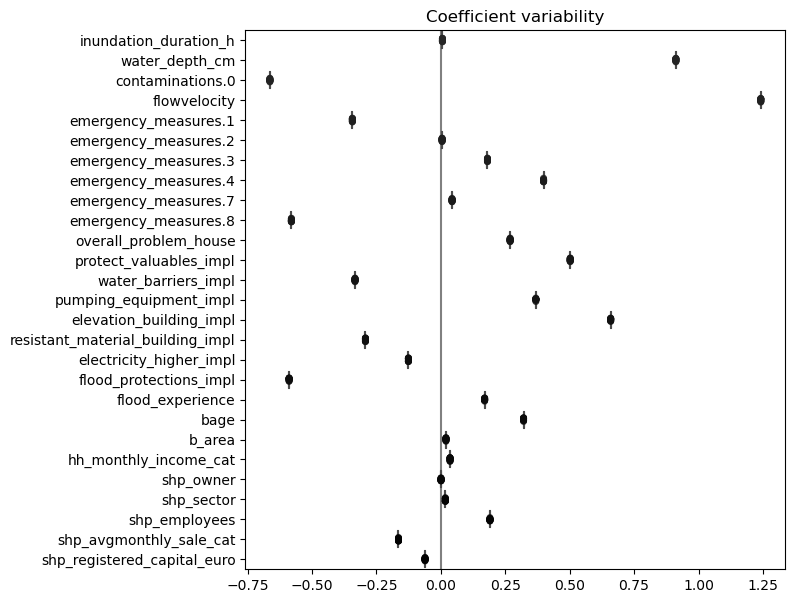

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="darkgrey", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

--> coefficients of flowvelocity and purchase pumping equipment varying a lot depneding of the fold
--> registered capital, average monthly sale, monthly income coefficients are varying a lot depending of the fold.

In [119]:
# logit_model=sm.Logit(y1,x1)
# result=logit_model.fit()
# print(result.summary())

### Confusion matrix

,0,1
0,97,61
1,54,56


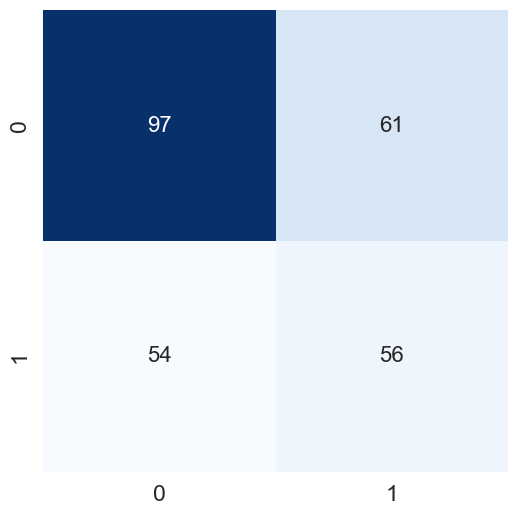

In [37]:
## based on neste cv
f.plot_confusion_matrix(
    predicted_probabilities["y_empirical"],
    predicted_probabilities["y_pred_value"],
    model_name="Logistic_Regression", target_name=target)

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean / variance / std  compared to empirical distribution

In [38]:
print("Logistic Reg (binary classification): ", target)
e.empirical_vs_predicted(
    X, y.astype(int),
    models_list=[model]    
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Logistic Reg (binary classification):  Target_relative_contentloss_euro


,nobs,median,mean,min max,variance
0,268,0,0,"[0, 1]",0.36
1,268,0,0,"[0, 1]",0.43


In [ ]:
#scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#pd.DataFrame(scores).set_index("test_score").sort_index().T

# #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
#pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
pd.DataFrame(model.cv_results_)[
        [                                   # only important cv evaluation metrics 
            "mean_test_score",
            "mean_fit_time",
            "rank_test_score",
            "param_name__estimator__C",
            "param_name__estimator__penalty",
            "param_name__estimator__l1_ratio",
            "param_name__estimator__max_iter"
        ]
    ].set_index("rank_test_score").sort_index().T


KeyError: "['param_name__estimator__C', 'param_name__estimator__penalty', 'param_name__estimator__l1_ratio', 'param_name__estimator__max_iter'] not in index"

In [ ]:
## reload models

print(targets)
target = targets[0]

logistic_reg_eval = pickle.load(open(f"./models_trained/logisticreg_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


### Feature importance

In [39]:
print("penalty term: L1=lasso, L2= rigde or elastic_net : " , model.best_params_["model__penalty"])


penalty term: L1=lasso, L2= rigde or elastic_net :  elasticnet


In [40]:
## TODO test to get std of FI _ C:\Users\Anna\Documents\UNI\MA_topic\recycling\sm2t-traffic-speed-model-partial-dependence\SM2T\sm2t-traffic-speed-model_partialDep\traffic_speed_model\modelling.py
#    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # based on RF_fi_ 

#plt.rcParams['axes.grid'] = 'none'
#s

<Figure size 3000x2200 with 0 Axes>

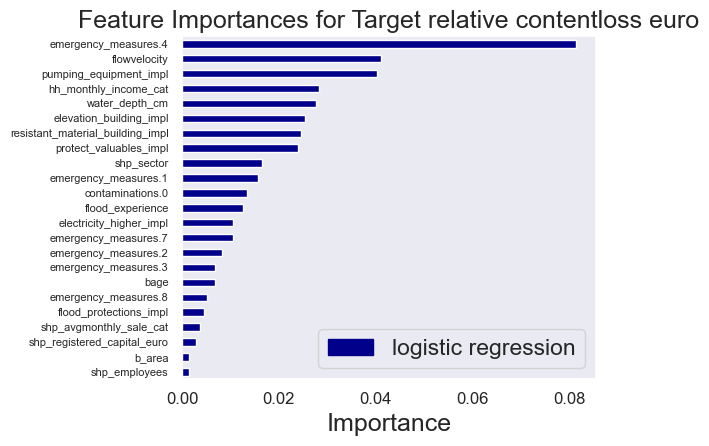

In [56]:
### drop features which dont reduce the loss
#df_feature_importances = s
df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances > 0.001, : ] 
df_feature_importances = df_feature_importances.sort_values("logreg_importances", ascending=True)

plt.figure(figsize=(30, 22), facecolor="w")
df_feature_importances.plot.barh(
    color="darkblue",
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="logistic regression")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
#plt.axes().set_facecolor("w")
plt.grid(False)
#plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



In [42]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")

### Plot optimal number of features

In [ ]:
elastic_net_eval.c

In [ ]:
# cv results
cv_results = pd.DataFrame(elastic_net_eval.cv_results_)
cv_results


AttributeError: 'ElasticNet' object has no attribute 'cv_results_'

In [ ]:

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
